# GAN Condicional para la generación de imágenes del conjunto FASHION-MNIST

#### Mateo López Torres
#### Master de Ciencia de Datos UV

#### *Script Original*: GAN_1_Really_Simple_GAN_MNIST_CONV_clase.ipynb

El objetivo de este script es modificar la GAN anterior para que, en vez de generar imágenes generales del dataset, general las imágenes de la etiqueta que deseemos (es decir, una GAN condicional). Empecé con el propio dataset MNIST, intentando que generara los números que yo eligiera, logrando muy buenos resultados con la GAN que venía por defecto en el script. Después de comprobar que la nueva arquitectura funcionaba, fui buscando nuevos datasets hasta llegar al Fashion MNIST, con el que me quedé para crear el modelo simple y el complejo.

Cabe destacar el uso de capas convolucionales en este problema, que en mi opinióin ayuda mucho a la hora de busqueda de patrones clave en imágenes, lo cual será de gran utilidad tanto en el discriminador como en el generador.

Tras el trabajo con el script, considero que se ha llegado al resultado deseado, es decir, un modelo que genera imágenes (en este caso prendas de ropa), a partir de las etiquetas que nosotros le solicitemos.

## Carga de Paquetes:

In [1]:
import os
import numpy as np
import pandas as pd

from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, Conv2D, UpSampling2D, MaxPool2D, Concatenate, Embedding, multiply
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Model
from tensorflow.keras.datasets import fashion_mnist,mnist
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
plt.switch_backend('agg')


## Funciones auxiliares:

Primero la función que define el modelo GAN a partir de un Generador y un Discriminador ya definidos:

In [2]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# get noise and label inputs from generator model
	gen_noise, gen_label = g_model.input
	# get image output from the generator model
	gen_output = g_model.output
	# connect image output and label input from generator as inputs to discriminator
	gan_output = d_model([gen_output, gen_label])
	# define gan model as taking noise and label and outputting a classification
	model = Model([gen_noise, gen_label], gan_output)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

Y ahora la función que se encarga de entrenar nuestra GAN en función de diferentes parámetros:

A la hora modificar la arquitectura de las redes para permitir la generación a partir de unas etiquetas específicas, hay que realizar unos cambios a a hora de definir el generador y el discrimiador como veremos más adelatne. El cambio principal es que el los modelos tendrán una entrada adicional, que consistirá en la lista de etiquetas a generar (a parte del ruido en caso del generador, y la imágen creada en caso del discriminador). Como se aprecia a la hora del entrenamiento, todo sigue siendo más o menos igual, a excepción del nuevo input en ambos casos, que se corresponde con la `y` (o etiqueta) correspondiente a las muestras que se introducen en cada batch para el entreno.

In [5]:
def gan_training(model_gen, model_disc,model_gan,X,y,num_classes,epochs=100,batch=16):

    DD_loss = np.zeros((epochs,))
    GG_loss = np.zeros((epochs,))

    for epoch in range(epochs):
        for _ in range(batch):

            # Select a random half batch of images
            idx = np.random.randint(0, X.shape[0], batch)
            imgs, labels = X[idx], y[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch, 100))
            gen_imgs = model_gen.predict([noise, labels])

            # Train the discriminator
            valid = np.ones((batch, 1))
            fake = np.zeros((batch, 1))

            d_loss_real = model_disc.train_on_batch([imgs, labels], valid)
            d_loss_fake = model_disc.train_on_batch([gen_imgs, labels], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Conditionally train the generator
            sampled_labels = np.random.randint(0, num_classes, batch).reshape(-1, 1)
            g_loss = model_gan.train_on_batch([noise, sampled_labels], valid)

        # Print the progress
        print("Epoch: %d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))

        DD_loss[epoch] = d_loss[0]
        GG_loss[epoch] = g_loss

    return DD_loss, GG_loss

# Dataset 1: MNIST

Para modificar la arquitectura de la red y crear una GAN condicional, empecé con el dataset que venía por defecto en el dataset, el MNIST. Lo hice así ya que las redes ya venían para con tamaño de entrada adecuado, y aparte los números son bastante diferenciables entre sí, por lo que el resultado debería ser (y es) bastante bueno.

In [6]:
(X_train_mnist, y_train_mnist), (X_test_mnist, y_test_mnist) = mnist.load_data()

X_mnist=np.concatenate([X_train_mnist,X_test_mnist])
y_mnist=np.concatenate([y_train_mnist,y_test_mnist])

# Rescale -1 to 1
X_mnist = (X_mnist.astype(np.float32) - 127.5) / 127.5
X_mnist = np.expand_dims(X_mnist, axis=-1)

width = 28
height = 28
channels = 1
num_classes = 10

in_shape = X_mnist.shape
in_shape = in_shape[1:]

num_nodes= in_shape[0] * in_shape[1]

OPTIMZADOR_ADAM = Adam(learning_rate=0.0005, beta_1=0.5)
OPTIMZADOR_ADAM_DISC = Adam(learning_rate=0.0002, beta_1=0.5)
OPTIMZADOR_ADAM_GAN = Adam(learning_rate=0.0002, beta_1=0.5)

Como hemos comentado anteriormente, vemos como en la nueva arquitectura, introducimos dos inputs, el ruido y las etiquetas, los cuales fusionamos tras una adaptación de su forma para empezar a aplicar las capas convolucionales.

In [7]:
# Generator

in_label = Input(shape=(1,))
li = Embedding(num_classes, 50)(in_label)
li = Dense(16*16)(li)
li = Reshape((16, 16, 1))(li)

in_lat = Input(shape=(100,))
gen = Dense(16*16*100)(in_lat)
gen = LeakyReLU(alpha=0.2)(gen)
gen = Reshape((16,16,100))(gen)
gen = BatchNormalization(momentum=0.8)(gen)

merge = Concatenate()([gen, li])
gen = Conv2D(100, 3)(merge)
gen = LeakyReLU(alpha=0.2)(gen)
gen = BatchNormalization(momentum=0.8)(gen)
gen = UpSampling2D(2)(gen)
gen = Conv2D(50, 3, activation='tanh', padding='SAME')(gen)
gen = LeakyReLU(alpha=0.2)(gen)
gen = BatchNormalization(momentum=0.8)(gen)
gen = Conv2D(1, 3, activation='tanh', padding='SAME')(gen)

model_gen = Model([in_lat, in_label], gen)
model_gen.compile(loss='binary_crossentropy', optimizer=OPTIMZADOR_ADAM, metrics=['accuracy'])

model_gen.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 25600)        2585600     ['input_2[0][0]']                
                                                                                                  
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 25600)        0           ['dense_1[0][0]']                
                                                                                              

Al igual que en el generador, en el discriminador también empezamos con dos inputs, la imagen creada por el generador y las etiquetas, lo cual fusionamos para empezar con las capas convolucionales.

In [8]:
# Discriminator

in_label = Input(shape=(1,))
li = Embedding(num_classes, 50)(in_label)
li = Dense(num_nodes)(li)
li = Reshape((in_shape[0], in_shape[1], 1))(li)

in_image = Input(shape=in_shape)
merge = Concatenate()([in_image, li])

fe = Conv2D(30, 3, input_shape=(28, 28, 2))(merge)
fe = LeakyReLU(alpha=0.2)(fe)
fe = MaxPool2D(2)(fe)
fe = Conv2D(30, 3)(fe)
fe = LeakyReLU(alpha=0.2)(fe)
fe = MaxPool2D(2)(fe)
fe = Flatten()(fe)
fe = Dense(1, activation='sigmoid')(fe)

model_Disc = Model([in_image, in_label], fe)
model_Disc.compile(loss='binary_crossentropy', optimizer=OPTIMZADOR_ADAM_DISC, metrics=['accuracy'])

model_Disc.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 50)        500         ['input_3[0][0]']                
                                                                                                  
 dense_2 (Dense)                (None, 1, 784)       39984       ['embedding_1[0][0]']            
                                                                                                  
 input_4 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                            

In [9]:
model_gan=define_gan(model_gen,model_Disc)

c:\Users\mateo\anaconda3\envs\tensor_gpu\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Trabajamos con los modelos por defecto, ya que tenemos la certeza de que el generador y el discriminador están bien equilibrados entre sí (uno no supera en rendimiento a otro) para nuestro dataset.

In [10]:
# Training loop
DD_loss, GG_loss = gan_training(model_gen, model_Disc,model_gan,X_mnist,y_mnist,num_classes,epochs=200,batch=128)

4/4 [==============================] - 0s 2ms/step
Epoch: 0 [D loss: 0.730385, acc.: 32.03%] [G loss: 0.659495]
4/4 [==============================] - 0s 2ms/step
Epoch: 1 [D loss: 0.717371, acc.: 25.39%] [G loss: 0.683081]
4/4 [==============================] - 0s 2ms/step
Epoch: 2 [D loss: 0.694280, acc.: 43.36%] [G loss: 0.685696]
4/4 [==============================] - 0s 2ms/step
Epoch: 3 [D loss: 0.702114, acc.: 39.45%] [G loss: 0.679069]
4/4 [==============================] - 0s 2ms/step
Epoch: 4 [D loss: 0.701936, acc.: 40.62%] [G loss: 0.677870]
4/4 [==============================] - 0s 2ms/step
Epoch: 5 [D loss: 0.694654, acc.: 50.78%] [G loss: 0.687899]
4/4 [==============================] - 0s 3ms/step
Epoch: 6 [D loss: 0.689669, acc.: 55.47%] [G loss: 0.704644]
4/4 [==============================] - 0s 3ms/step
Epoch: 7 [D loss: 0.688574, acc.: 56.64%] [G loss: 0.701753]
4/4 [==============================] - 0s 2ms/step
Epoch: 8 [D loss: 0.687642, acc.: 53.91%] [G loss: 0.

Ya que yo ejecutaba el script en local, me guardaba los modelos para luego no tener que volverlo a ejecutar nuevamente. En caso de ejecutarlo en colab, este código sobra.

In [11]:
#model_gen.save('./models/Generators/model_gen_mnist.keras')
#model_Disc.save('./models/Discriminators/model_disc_mnist.keras')
#model_gan.save('./models/GANs/model_gan_mnist.keras')

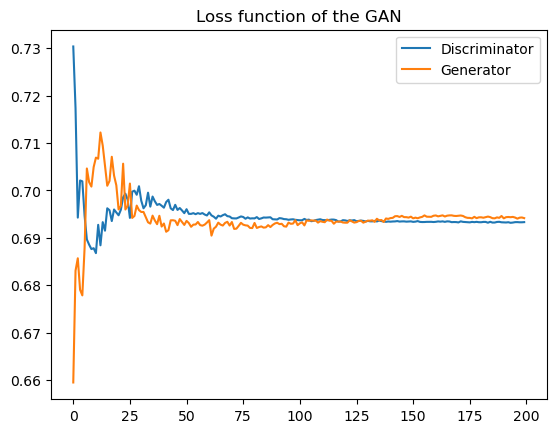

In [12]:
%matplotlib inline
plt.figure
plt.plot(DD_loss,label="Discriminator")
plt.plot(GG_loss,label="Generator")
plt.legend()
plt.title("Loss function of the GAN")
plt.show()

Viendo esta curva, hay que decir que, dado que la pérdida de una red depende de la eficacia de la otra, no es necesario obtener una pérdida muy baja en ambas redes (de 0.1) por ejemplo para conseguir un mejor modelo. Simplemente es necesario que converga durante el tiempo suficiente, aunque el valor de la convergencia no sea especialmente bajo, ya que eso significa que ambas redes han encontrado el equilibrio donde ambas aprenden, sin que una supere a la otra (la cual acabaría por estancarse).

Una vez entrenado nuestro modelo y viendo como las curvas de pérdida de ambos modelos acaban convergiendo, vamos a generar imágenes en base a ciertas etiquetas, para comprobar la eficacia de nuestro modelo condicional.

In [75]:
gen_noise = np.random.normal(0, 1, (np.int64(10), 100))
gen_labels= np.array([0,1,2,3,4,5,6,7,8,9])

syntetic_images = model_gen.predict([gen_noise,gen_labels])

syntetic_images.shape

1/1 [==============================] - 0s 24ms/step


(10, 28, 28, 1)

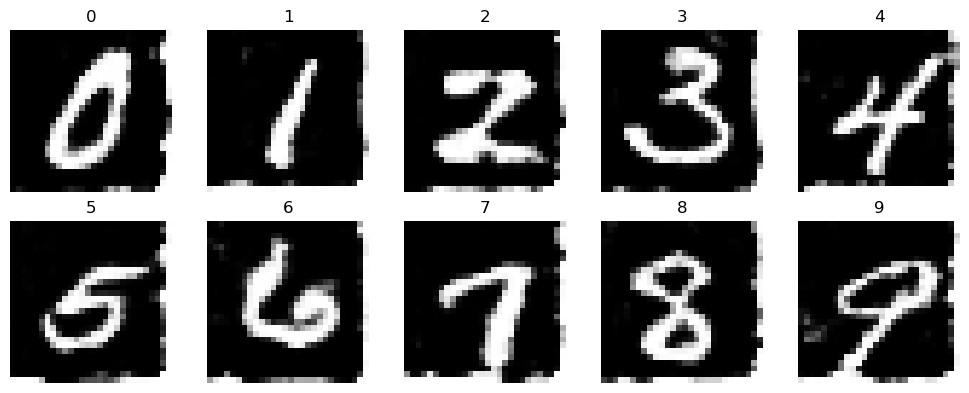

In [76]:
fig, axs = plt.subplots(2, 5, figsize=(10, 4))

for i in range(2):
    for j in range(5):
        idx = i * 5 + j

        axs[i, j].imshow(syntetic_images[idx, :, :, 0], cmap='gray')
        axs[i, j].axis('off')
        axs[i, j].set_title(gen_labels[idx])

plt.tight_layout()
plt.show()

Vemos como el resultado es considerablemente bueno, viendo como se distinguen clarísimamente los números que se están generando. Dado que este dataset es demasiado sencillo, vamos a intentar complicar un poco más las cosas, y vamos a explorar otros datasets distintos.

# Dataset 2: EMNIST Letters

Para facilitar la adaptación del código ya implementado para el MNIST, probé a usar el EMNIST de letras, que es un dataset similar, solo que tomando las letras del alfabeto (26 clases en total), que es una buena alternativa, aumentando la dificultad, pero manteniendo el formato y la arquitectura, que es de los mayores problemas a la hora de implementar una GAN.

Dado que el EMNIST no está implementado en una libraría de python (al menos no una que me funcionara:( ), decidí buscarlo en Kaggle y descargarlo, ya que no es un csv excesívamente grande. 

In [15]:
data_train=pd.read_csv("./data/emnist-letters-train.csv")
data_test=pd.read_csv("./data/emnist-letters-test.csv")

X_train_emnist = data_train.iloc[:, 1:].values
X_test_emnist = data_test.iloc[:, 1:].values

y_train_emnist = data_train.iloc[:, 0].values
y_test_emnist = data_test.iloc[:, 0].values

X_emnist=np.concatenate([X_train_emnist,X_test_emnist])
y_emnist=np.concatenate([y_train_emnist,y_test_emnist])

X_emnist=X_emnist.reshape(-1, 28, 28)
X_emnist = np.expand_dims(X_emnist, axis=-1)

width = 28
height = 28
channels = 1
num_classes = 26

in_shape = X_emnist.shape
in_shape = in_shape[1:]

num_nodes= in_shape[0] * in_shape[1]

OPTIMZADOR_ADAM = Adam(learning_rate=0.0002, beta_1=0.5)
OPTIMZADOR_ADAM_DISC = Adam(learning_rate=0.0001, beta_1=0.5)

Por los resultados que se explican luego, esta vez si que decidí cambiar la arquitectura de la red, ya que había un claro desbalance entre ambas redes (el discriminador siempre acababa superando al generador, lo cual no le permitía al segundo seguir aprendiendo). Por ello, he hecho un generador muy complejo y un discriminador muy simple para probar este último punto.

In [35]:
# Generator

in_label = Input(shape=(1,))
li = Embedding(num_classes, 50)(in_label)
li = Dense(16*16)(li)
li = Reshape((16, 16, 1))(li)

in_lat = Input(shape=(100,))
gen = Dense(16*16*100)(in_lat)
gen = LeakyReLU(alpha=0.2)(gen)
gen = Reshape((16,16,100))(gen)
gen = BatchNormalization(momentum=0.8)(gen)

merge = Concatenate()([gen, li])
gen = Conv2D(300, 3)(merge)
gen = LeakyReLU(alpha=0.2)(gen)
gen = BatchNormalization(momentum=0.8)(gen)
gen = UpSampling2D(2)(gen)
gen = Conv2D(200, 3, activation='tanh', padding='SAME')(gen)
gen = LeakyReLU(alpha=0.2)(gen)
gen = BatchNormalization(momentum=0.8)(gen)
gen = Conv2D(100, 3, activation='tanh', padding='SAME')(gen)
gen = LeakyReLU(alpha=0.2)(gen)
gen = BatchNormalization(momentum=0.8)(gen)
gen = Conv2D(1, 3, activation='tanh', padding='SAME')(gen)

OPTIMZADOR_ADAM = Adam(learning_rate=0.0005, beta_1=0.5)
model_gen1 = Model([in_lat, in_label], gen)
model_gen1.compile(loss='binary_crossentropy', optimizer=OPTIMZADOR_ADAM, metrics=['accuracy'])

model_gen1.summary()


Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 dense_19 (Dense)               (None, 25600)        2585600     ['input_20[0][0]']               
                                                                                                  
 input_19 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 leaky_re_lu_24 (LeakyReLU)     (None, 25600)        0           ['dense_19[0][0]']               
                                                                                           

In [36]:
# Discriminator

in_label = Input(shape=(1,))
li = Dense(num_nodes)(in_label)
li = Reshape((in_shape[0], in_shape[1], 1))(li)

in_image = Input(shape=in_shape)
merge = Concatenate()([in_image, li])

fe = Conv2D(5, 3, input_shape=(28, 28, 2))(merge)
fe = LeakyReLU(alpha=0.2)(fe)
fe = MaxPool2D(4)(fe)
fe = Flatten()(fe)
fe = Dense(1, activation='sigmoid')(fe)

model_Disc1 = Model([in_image, in_label], fe)
model_Disc1.compile(loss='binary_crossentropy', optimizer=OPTIMZADOR_ADAM_DISC, metrics=['accuracy'])

model_Disc1.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 dense_20 (Dense)               (None, 784)          1568        ['input_21[0][0]']               
                                                                                                  
 input_22 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 reshape_15 (Reshape)           (None, 28, 28, 1)    0           ['dense_20[0][0]']               
                                                                                           

In [37]:
model_gan1=define_gan(model_gen1,model_Disc1)

In [38]:
DD_loss, GG_loss = gan_training(model_gen1, model_Disc1,model_gan1,X_emnist,y_emnist,num_classes,epochs=100,batch=64)

2/2 [==============================] - 0s 7ms/step
Epoch: 0 [D loss: 0.610059, acc.: 75.78%] [G loss: 1.475946]
2/2 [==============================] - 0s 14ms/step
Epoch: 1 [D loss: 0.472231, acc.: 76.56%] [G loss: 2.671797]
2/2 [==============================] - 0s 15ms/step
Epoch: 2 [D loss: 0.376029, acc.: 82.03%] [G loss: 3.829497]
2/2 [==============================] - 0s 11ms/step
Epoch: 3 [D loss: 0.267379, acc.: 85.16%] [G loss: 5.119558]
2/2 [==============================] - 0s 11ms/step
Epoch: 4 [D loss: 0.203997, acc.: 90.62%] [G loss: 4.787098]
2/2 [==============================] - 0s 12ms/step
Epoch: 5 [D loss: 0.164012, acc.: 89.84%] [G loss: 5.840961]
2/2 [==============================] - 0s 7ms/step
Epoch: 6 [D loss: 0.165470, acc.: 89.84%] [G loss: 6.781374]
2/2 [==============================] - 0s 12ms/step
Epoch: 7 [D loss: 0.240502, acc.: 89.06%] [G loss: 7.329347]
2/2 [==============================] - 0s 14ms/step
Epoch: 8 [D loss: 0.123006, acc.: 93.75%] [G l

In [39]:
#model_gen1.save('./models/Generators/model_gen_emnist.keras')
#model_Disc1.save('./models/Discriminators/model_disc_emnist.keras')
#model_gan1.save('./models/GANs/model_gan_emnist.keras')

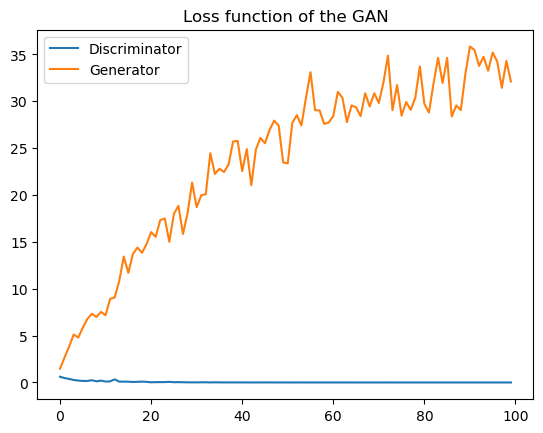

In [40]:
%matplotlib inline

plt.figure
plt.plot(DD_loss,label="Discriminator")
plt.plot(GG_loss,label="Generator")
plt.legend()
plt.title("Loss function of the GAN")
plt.show()

Vemos como al final, por mucho cambio que se haga, el generador siempre acaba siendo superando por el discriminador. Explorando el dataset, he podido ver que las letras están todas rotadas, y al final, al no haber tantos datos, es bastante complicado generar imágenes por etiqueta. En mi opinión, este dataset está más pensado para clasificación (de ahí la rotación de las imágenes), y no para generación, ya que ese cambio lo complica todo.

In [41]:
gen_noise = np.random.normal(0, 1, (np.int64(10), 100))
gen_labels= np.array([1,2,3,4,5,6,7,8,9,10])

syntetic_images = model_gen1.predict([gen_noise,gen_labels])

syntetic_images.shape

1/1 [==============================] - 0s 92ms/step


(10, 28, 28, 1)

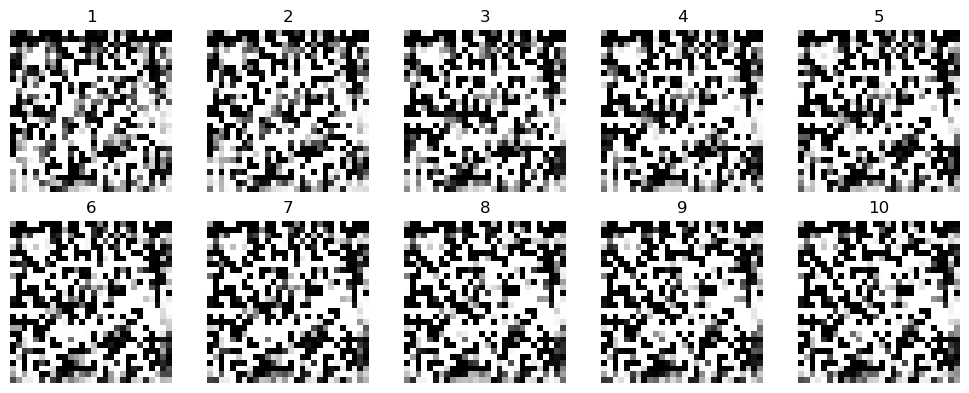

In [42]:
fig, axs = plt.subplots(2, 5, figsize=(10, 4))

for i in range(2):
    for j in range(5):
        idx = i * 5 + j

        axs[i, j].imshow(syntetic_images[idx, :, :, 0], cmap='gray')
        axs[i, j].axis('off')
        axs[i, j].set_title(gen_labels[idx])

plt.tight_layout()
plt.show()

A la vista de los pésimos resultados, decidí que el EMNIST no era mi dataset, y me puse a buscar otro. Como me empeñé en que el formato de las imágenes fuera el mismo, decidí irme por otro dataset de la familia, al Fashion-MNIST.

# Dataset 3: Fashion-MNIST

Este será el dataset definitivo con el que probaremos diferentes modelos, dado su formato sencillo y su buena diferenciación, ya que es algo más complicado de el MNIST, pero al ser solo 10 clases e imágenes en blanco y negro (1 solo canal), podemos suponer que los resultados serán bastante aceptables.

## Metadata:

El significado de las etiquetas es:

0 -> T-shirt/top

1 -> Trouser

2 -> Pullover

3 -> Dress

4 -> Coat

5 -> Sandal

6 -> Shirt

7 -> Sneaker

8 -> Bag

9 -> Ankle boot

Primero, cargamos los datos:

In [47]:
(X_train_fashion, y_train_fashion), (X_test_fashion, y_test_fashion) = fashion_mnist.load_data()

X_fashion=np.concatenate([X_train_fashion,X_test_fashion])
y_fashion=np.concatenate([y_train_fashion,y_test_fashion])

# Rescale -1 to 1
X_fashion = (X_fashion.astype(np.float32) - 255.0) / 255.0
X_fashion = np.expand_dims(X_fashion, axis=-1)

width = 28
height = 28
channels = 1
num_classes = 10
etiquetas = ["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]

in_shape = X_fashion.shape
in_shape = in_shape[1:]

num_nodes= in_shape[0] * in_shape[1]

OPTIMZADOR_ADAM = Adam(learning_rate=0.0002, beta_1=0.5)
OPTIMZADOR_ADAM_DISC = Adam(learning_rate=0.0002, beta_1=0.5)
OPTIMZADOR_ADAM_GAN = Adam(learning_rate=0.0002, beta_1=0.5)

## Modelo incial

In [32]:
# Generator

in_label = Input(shape=(1,))
li = Embedding(num_classes, 50)(in_label)
li = Dense(16*16)(li)
li = Reshape((16, 16, 1))(li)

in_lat = Input(shape=(100,))
gen = Dense(16*16*100)(in_lat)
gen = LeakyReLU(alpha=0.2)(gen)
gen = Reshape((16,16,100))(gen)
gen = BatchNormalization(momentum=0.8)(gen)

merge = Concatenate()([gen, li])
gen = Conv2D(100, 3)(merge)
gen = LeakyReLU(alpha=0.2)(gen)
gen = BatchNormalization(momentum=0.8)(gen)
gen = UpSampling2D(2)(gen)
gen = Conv2D(50, 3, activation='tanh', padding='SAME')(gen)
gen = LeakyReLU(alpha=0.2)(gen)
gen = BatchNormalization(momentum=0.8)(gen)
gen = Conv2D(1, 3, activation='tanh', padding='SAME')(gen)

model_gen2 = Model([in_lat, in_label], gen)
model_gen2.compile(loss='binary_crossentropy', optimizer=OPTIMZADOR_ADAM, metrics=['accuracy'])

model_gen2.summary()


Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 dense_13 (Dense)               (None, 25600)        2585600     ['input_14[0][0]']               
                                                                                                  
 input_13 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 leaky_re_lu_14 (LeakyReLU)     (None, 25600)        0           ['dense_13[0][0]']               
                                                                                            

In [33]:
# Discriminator

in_label = Input(shape=(1,))
li = Embedding(num_classes, 50)(in_label)
li = Dense(num_nodes)(li)
li = Reshape((in_shape[0], in_shape[1], 1))(li)

in_image = Input(shape=in_shape)
merge = Concatenate()([in_image, li])

fe = Conv2D(40, 3, input_shape=(28, 28, 2))(merge)
fe = LeakyReLU(alpha=0.2)(fe)
fe = MaxPool2D(2)(fe)
fe = Conv2D(30, 3)(fe)
fe = LeakyReLU(alpha=0.2)(fe)
fe = MaxPool2D(2)(fe)
fe = Flatten()(fe)
fe = Dense(1, activation='sigmoid')(fe)

model_Disc2 = Model([in_image, in_label], fe)
model_Disc2.compile(loss='binary_crossentropy', optimizer=OPTIMZADOR_ADAM_DISC, metrics=['accuracy'])

model_Disc2.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, 1, 50)        500         ['input_15[0][0]']               
                                                                                                  
 dense_14 (Dense)               (None, 1, 784)       39984       ['embedding_6[0][0]']            
                                                                                                  
 input_16 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                           

In [34]:
model_gan2=define_gan(model_gen2,model_Disc2)

In [35]:
DD_loss, GG_loss = gan_training(model_gen2, model_Disc2,model_gan2,X_fashion,y_fashion,num_classes,epochs=200,batch=64)

2/2 [==============================] - 0s 3ms/step
Epoch: 0 [D loss: 0.525841, acc.: 92.97%] [G loss: 1.093752]
2/2 [==============================] - 0s 3ms/step
Epoch: 1 [D loss: 0.597220, acc.: 77.34%] [G loss: 0.966670]
2/2 [==============================] - 0s 3ms/step
Epoch: 2 [D loss: 0.707853, acc.: 61.72%] [G loss: 0.786360]
2/2 [==============================] - 0s 4ms/step
Epoch: 3 [D loss: 0.750249, acc.: 36.72%] [G loss: 0.581182]
2/2 [==============================] - 0s 4ms/step
Epoch: 4 [D loss: 0.712639, acc.: 46.88%] [G loss: 0.623927]
2/2 [==============================] - 0s 3ms/step
Epoch: 5 [D loss: 0.691675, acc.: 37.50%] [G loss: 0.680625]
2/2 [==============================] - 0s 3ms/step
Epoch: 6 [D loss: 0.698344, acc.: 38.28%] [G loss: 0.683084]
2/2 [==============================] - 0s 3ms/step
Epoch: 7 [D loss: 0.679705, acc.: 62.50%] [G loss: 0.713683]
2/2 [==============================] - 0s 3ms/step
Epoch: 8 [D loss: 0.678755, acc.: 63.28%] [G loss: 0.

In [36]:
#model_gen2.save('./models/Generators/model_gen_fashion.keras')
#model_Disc2.save('./models/Discriminators/model_disc_fashion.keras')
#model_gan2.save('./models/GANs/model_gan_fashion.keras')

Epoch: 199 [D loss: 0.694277, acc.: 32.03%] [G loss: 0.693609]


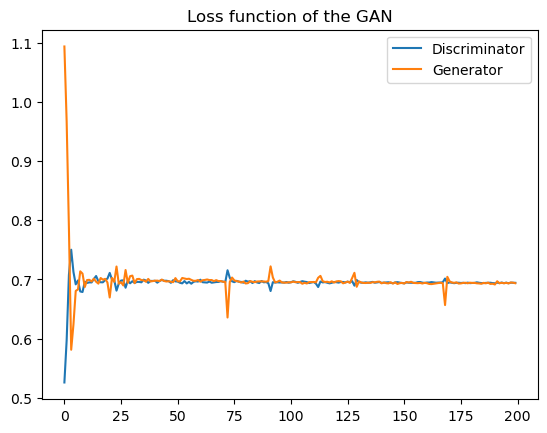

In [37]:
%matplotlib inline

plt.figure
plt.plot(DD_loss,label="Discriminator")
plt.plot(GG_loss,label="Generator")
plt.legend()
plt.title("Loss function of the GAN")
plt.show()

Vemos como este modelo converge de una forma bastante rápida, pero aun así, es bueno dejarlo entrenar, ya que en ese momento la red continúa aprendiendo y compensandose entre generador y discriminador.

In [38]:
gen_noise = np.random.normal(0, 1, (np.int64(10), 100))
gen_labels= np.array([0,1,2,3,4,5,6,7,8,9])

syntetic_images = model_gen2.predict([gen_noise,gen_labels])

syntetic_images.shape

1/1 [==============================] - 0s 89ms/step


(10, 28, 28, 1)

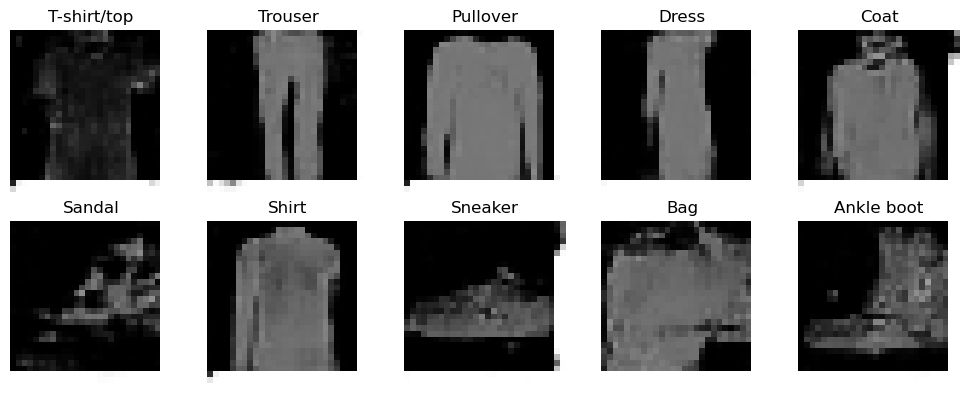

In [39]:
fig, axs = plt.subplots(2, 5, figsize=(10, 4))

for i in range(2):
    for j in range(5):
        idx = i * 5 + j

        axs[i, j].imshow(syntetic_images[idx, :, :, 0], cmap='gray')
        axs[i, j].axis('off')
        axs[i, j].set_title(etiquetas[idx])

plt.tight_layout()
plt.show()

Vemos comoel resultado es bastante aceptable (hay algunas imágenes peores que otras claro está). Pero por ejemplo los pantalones, camisetas y botas son perfectamente distinguibles del resto, por lo que podemos tomar este resultado como un éxito. Vamos a probar ahora otros mnodelos, simple y complejo, aunque veremos que en ambos casos solo conseguiremos empeorar el resultado (muchas veces menos es más, pero no demasiado menos...).

## Modelo Simple

Para empezar, en el generador, vamos a reducir mucho el tamaño del embedding, y principalmente, el número de filtros en las convolucionales, aunque si que mantenemos la misma estructura. De esta forma reducimos de cerca de 3 millones de parámetros a medio millón, lo cual es una reducción más que considerable.

In [79]:
# Generator simple

in_label = Input(shape=(1,))
li = Embedding(num_classes, 10)(in_label)
li = Dense(7*7)(li)
li = Reshape((7, 7, 1))(li)

in_lat = Input(shape=(100,))
gen = Dense(7*7*100)(in_lat)
gen = LeakyReLU(alpha=0.2)(gen)
gen = Reshape((7,7,100))(gen)
gen = BatchNormalization(momentum=0.8)(gen)

merge = Concatenate()([gen, li])
gen = Conv2D(5, 3, padding='SAME')(merge)
gen = LeakyReLU(alpha=0.2)(gen)
gen = BatchNormalization(momentum=0.8)(gen)
gen = UpSampling2D(4)(gen)
gen = Conv2D(1, 3, activation='tanh', padding='SAME')(gen)

model_gen3 = Model([in_lat, in_label], gen)
model_gen3.compile(loss='binary_crossentropy', optimizer=OPTIMZADOR_ADAM, metrics=['accuracy'])

model_gen3.summary()



Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_28 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 dense_27 (Dense)               (None, 4900)         494900      ['input_28[0][0]']               
                                                                                                  
 input_27 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 leaky_re_lu_36 (LeakyReLU)     (None, 4900)         0           ['dense_27[0][0]']               
                                                                                           

En el discriminador el mayor cambio es reducir el tamaño de la capa densa del principio, que es de donde vienen la mayoría de los parámetros. A su vez reducimos nuevamente el número de filtros en las convolucionales.

In [80]:
# Discriminator simple

in_label = Input(shape=(1,))
li = Dense(int(num_nodes/16))(in_label)
li = Reshape((int(in_shape[0]/4),int(in_shape[1]/4), 1))(li)
li = UpSampling2D(4)(li)

in_image = Input(shape=in_shape)
merge = Concatenate()([in_image, li])

fe = Conv2D(1, 3, input_shape=(28, 28, 2))(merge)
fe = MaxPool2D(8)(fe)
fe = Flatten()(fe)
fe = Dense(1, activation='sigmoid')(fe)

model_Disc3 = Model([in_image, in_label], fe)
model_Disc3.compile(loss='binary_crossentropy', optimizer=OPTIMZADOR_ADAM_DISC, metrics=['accuracy'])

model_Disc3.summary()

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_29 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 dense_28 (Dense)               (None, 49)           98          ['input_29[0][0]']               
                                                                                                  
 reshape_21 (Reshape)           (None, 7, 7, 1)      0           ['dense_28[0][0]']               
                                                                                                  
 input_30 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                           

In [81]:
model_gan3=define_gan(model_gen3,model_Disc3)

In [82]:
DD_loss, GG_loss = gan_training(model_gen3, model_Disc3,model_gan3,X_fashion,y_fashion,num_classes,epochs=300,batch=64)

2/2 [==============================] - 0s 2ms/step
Epoch: 0 [D loss: 1.086739, acc.: 55.47%] [G loss: 1.521394]
2/2 [==============================] - 0s 3ms/step
Epoch: 1 [D loss: 0.992833, acc.: 53.91%] [G loss: 0.899298]
2/2 [==============================] - 0s 3ms/step
Epoch: 2 [D loss: 0.986821, acc.: 28.12%] [G loss: 0.717526]
2/2 [==============================] - 0s 2ms/step
Epoch: 3 [D loss: 0.958130, acc.: 25.00%] [G loss: 0.665344]
2/2 [==============================] - 0s 5ms/step
Epoch: 4 [D loss: 0.916874, acc.: 23.44%] [G loss: 0.597578]
2/2 [==============================] - 0s 3ms/step
Epoch: 5 [D loss: 0.933025, acc.: 25.00%] [G loss: 0.609933]
2/2 [==============================] - 0s 2ms/step
Epoch: 6 [D loss: 0.901519, acc.: 21.88%] [G loss: 0.579142]
2/2 [==============================] - 0s 5ms/step
Epoch: 7 [D loss: 0.896113, acc.: 18.75%] [G loss: 0.635275]
2/2 [==============================] - 0s 2ms/step
Epoch: 8 [D loss: 0.863330, acc.: 21.09%] [G loss: 0.

In [83]:
#model_gen3.save('./models/Generators/model_gen_fashion_simple.keras')
#model_Disc3.save('./models/Discriminators/model_disc_fashion_simple.keras')
#model_gan3.save('./models/GANs/model_gan_fashion_simple.keras')

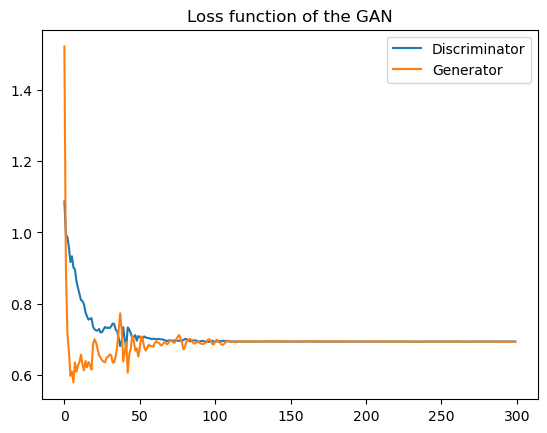

In [84]:
%matplotlib inline

plt.figure
plt.plot(DD_loss,label="Discriminator")
plt.plot(GG_loss,label="Generator")
plt.legend()
plt.title("Loss function of the GAN")
plt.show()

In [85]:
gen_noise = np.random.normal(0, 1, (np.int64(10), 100))
gen_labels= np.array([0,1,2,3,4,5,6,7,8,9])

syntetic_images = model_gen3.predict([gen_noise,gen_labels])

syntetic_images.shape

1/1 [==============================] - 0s 241ms/step


(10, 28, 28, 1)

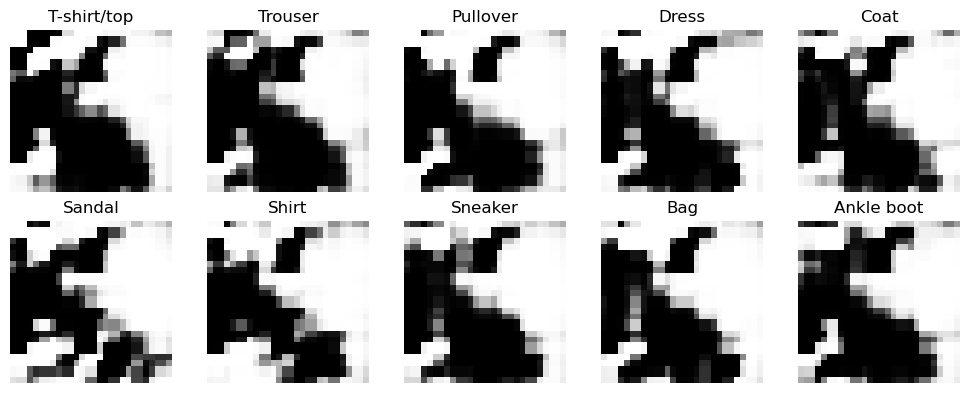

In [86]:
fig, axs = plt.subplots(2, 5, figsize=(10, 4))

for i in range(2):
    for j in range(5):
        idx = i * 5 + j

        axs[i, j].imshow(syntetic_images[idx, :, :, 0], cmap='gray')
        axs[i, j].axis('off')
        axs[i, j].set_title(etiquetas[idx])

plt.tight_layout()
plt.show()

Vemos en este caso una clara convergencia, en un error prácticamente idéntico que en el anterior. En cambio, basta con ver el resultado. Este es un ejemplo de como una convergencia en un cierto error no implica la calidad del modelo, sea grande o pequeño el error donde se converga. En este caso, dado la simplicidad del modelo, pedirle la generación de imágenes quizás es aspirar a mucho, por lo que hay que buscar algo más de complejidad para una tarea tán complicada como la generación de imágenes.

## Modelo Complejo

Simplemente comentar que para el modelo complejo se han añadido capas y se han complicado las ya existentes (más filtros, tamaño de las densas, etc.), siempre respetando la estructura base de nuestras redes anteriores (si algo funciona es mejor no toquetearlo mucho).

In [43]:
# Generator complicado

in_label = Input(shape=(1,))
li = Embedding(num_classes, 50)(in_label)
li = Dense(16*16)(li)
li = Reshape((16, 16, 1))(li)

in_lat = Input(shape=(100,))
gen = Dense(16*16*100)(in_lat)
gen = LeakyReLU(alpha=0.2)(gen)
gen = Reshape((16,16,100))(gen)
gen = BatchNormalization(momentum=0.8)(gen)

merge = Concatenate()([gen, li])
gen = Conv2D(300, 3)(merge)
gen = LeakyReLU(alpha=0.2)(gen)
gen = BatchNormalization(momentum=0.8)(gen)
gen = UpSampling2D(2)(gen)
gen = Conv2D(200, 3, activation='tanh', padding='SAME')(gen)
gen = LeakyReLU(alpha=0.2)(gen)
gen = BatchNormalization(momentum=0.8)(gen)
gen = Conv2D(100, 3, activation='tanh', padding='SAME')(gen)
gen = LeakyReLU(alpha=0.2)(gen)
gen = BatchNormalization(momentum=0.8)(gen)
gen = Conv2D(1, 3, activation='tanh', padding='SAME')(gen)

OPTIMZADOR_ADAM = Adam(learning_rate=0.0005, beta_1=0.5)
model_gen4 = Model([in_lat, in_label], gen)
model_gen4.compile(loss='binary_crossentropy', optimizer=OPTIMZADOR_ADAM, metrics=['accuracy'])

model_gen4.summary()


Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 dense_23 (Dense)               (None, 25600)        2585600     ['input_24[0][0]']               
                                                                                                  
 input_23 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 leaky_re_lu_29 (LeakyReLU)     (None, 25600)        0           ['dense_23[0][0]']               
                                                                                           

In [44]:
# Discriminator complicado

in_label = Input(shape=(1,))
li = Embedding(num_classes, 100)(in_label)
li = Dense(num_nodes)(li)
li = Reshape((in_shape[0], in_shape[1], 1))(li)

in_image = Input(shape=in_shape)
merge = Concatenate()([in_image, li])

fe = Conv2D(90, 3, input_shape=(28, 28, 2))(merge)
fe = LeakyReLU(alpha=0.2)(fe)
fe = MaxPool2D(2)(fe)
fe = Conv2D(50, 3)(fe)
fe = LeakyReLU(alpha=0.2)(fe)
fe = MaxPool2D(2)(fe)
fe = Conv2D(30, 3)(fe)
fe = LeakyReLU(alpha=0.2)(fe)
fe = Flatten()(fe)
fe = Dense(1, activation='sigmoid')(fe)

model_Disc4 = Model([in_image, in_label], fe)
model_Disc4.compile(loss='binary_crossentropy', optimizer=OPTIMZADOR_ADAM_DISC, metrics=['accuracy'])

model_Disc4.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_8 (Embedding)        (None, 1, 100)       2600        ['input_25[0][0]']               
                                                                                                  
 dense_24 (Dense)               (None, 1, 784)       79184       ['embedding_8[0][0]']            
                                                                                                  
 input_26 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                           

In [45]:
model_gan4=define_gan(model_gen4,model_Disc4)

In [48]:
DD_loss, GG_loss = gan_training(model_gen4, model_Disc4,model_gan4,X_fashion,y_fashion,num_classes,epochs=200,batch=64)

2/2 [==============================] - 0s 7ms/step
Epoch: 0 [D loss: 0.343040, acc.: 91.41%] [G loss: 1.994280]
2/2 [==============================] - 0s 7ms/step
Epoch: 1 [D loss: 0.401349, acc.: 83.59%] [G loss: 1.630003]
2/2 [==============================] - 0s 7ms/step
Epoch: 2 [D loss: 0.681524, acc.: 53.91%] [G loss: 0.739383]
2/2 [==============================] - 0s 11ms/step
Epoch: 3 [D loss: 0.661350, acc.: 58.59%] [G loss: 0.719252]
2/2 [==============================] - 0s 6ms/step
Epoch: 4 [D loss: 0.696530, acc.: 45.31%] [G loss: 0.691136]
2/2 [==============================] - 0s 7ms/step
Epoch: 5 [D loss: 0.687116, acc.: 55.47%] [G loss: 0.720611]
2/2 [==============================] - 0s 21ms/step
Epoch: 6 [D loss: 0.710283, acc.: 38.28%] [G loss: 0.673327]
2/2 [==============================] - 0s 16ms/step
Epoch: 7 [D loss: 0.690895, acc.: 37.50%] [G loss: 0.668498]
2/2 [==============================] - 0s 7ms/step
Epoch: 8 [D loss: 0.667167, acc.: 50.78%] [G loss:

In [49]:
#model_gen4.save('./models/Generators/model_gen_fashion_complex.keras')
#model_Disc4.save('./models/Discriminators/model_disc_fashion_complex.keras')
#model_gan4.save('./models/GANs/model_gan_fashion_complex.keras')

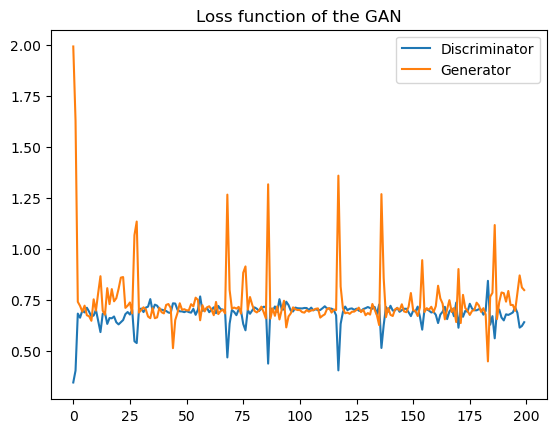

In [50]:
%matplotlib inline

plt.figure
plt.plot(DD_loss,label="Discriminator")
plt.plot(GG_loss,label="Generator")
plt.legend()
plt.title("Loss function of the GAN")
plt.show()

Vemos como esta curva no termina de converger, pero dado que tardaba en entrenar 1:15h, he intentado que converja lo máximo posible.

In [87]:
gen_noise = np.random.normal(0, 1, (np.int64(10), 100))
gen_labels= np.array([0,1,2,3,4,5,6,7,8,9])

syntetic_images = model_gen4.predict([gen_noise,gen_labels])

syntetic_images.shape

1/1 [==============================] - 0s 20ms/step


(10, 28, 28, 1)

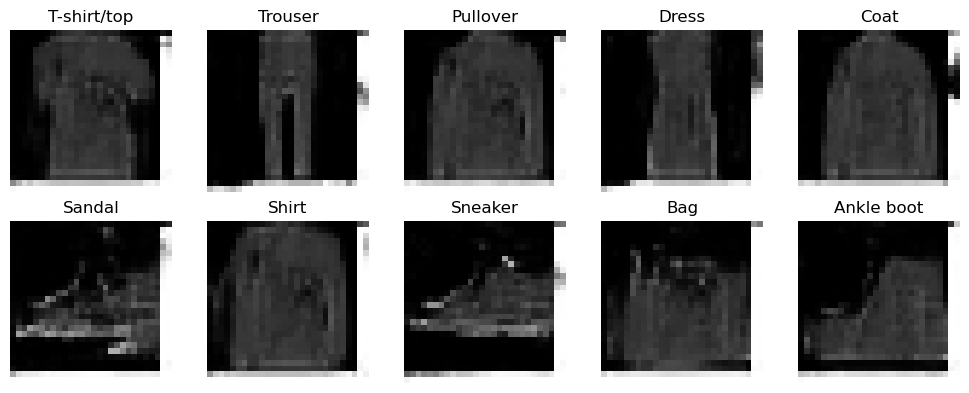

In [88]:
fig, axs = plt.subplots(2, 5, figsize=(10, 4))

for i in range(2):
    for j in range(5):
        idx = i * 5 + j

        axs[i, j].imshow(syntetic_images[idx, :, :, 0], cmap='gray')
        axs[i, j].axis('off')
        axs[i, j].set_title(etiquetas[idx])

plt.tight_layout()
plt.show()

Vemos como esta red funciona al igual que la primera propuesta, pero sinceramente, no merece la pena el tiempo de espera extra en el entreno (alrededor de 30 min) para unos resultados muy similares.

Aun así, como conclusión, vemos como finalmente hemos logrado nuestro objetivo, que es una GAN que consiga generar las imágenes en función de las etiquetas que deseemos. Lo más complicado es adaptar la arquitectura, y sobretodo, conseguir encontrar un equilibrio entre el generador y el discriminador, de forma que uno no acabe superando al otro, y ambos acaben aprendiendo a la misma velocidad, aumentando cada vez más su precisión.